## Import

In [1]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import f1_score, classification_report, recall_score, accuracy_score



# Variables

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [3]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = y_train.unique()
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

## Data Load

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# Create Train&Test sets of data

In [5]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df[['Y_Class']]

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])



In [5]:
train_x.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,349.000000,349.0,...,100.000000,100.00000,100.000000,100.000000,100.00000,99.0,0.0,0.0,0.0,0.0
mean,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,41.469914,2.0,...,50.807300,53.60770,49.606200,51.659800,66.64970,1.0,NaN,NaN,NaN,NaN
std,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,10.515032,0.0,...,7.011828,8.13899,7.158917,8.913065,4.52781,0.0,NaN,NaN,NaN,NaN
min,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,32.120000,31.70000,32.560000,30.490000,61.67000,1.0,NaN,NaN,NaN,NaN
25%,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.485000,52.20000,42.160000,49.915000,63.64500,1.0,NaN,NaN,NaN,NaN
50%,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,53.425000,55.92500,51.460000,56.175000,65.14000,1.0,NaN,NaN,NaN,NaN
75%,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,52.000000,2.0,...,55.287500,58.97500,55.030000,57.175000,67.11500,1.0,NaN,NaN,NaN,NaN
max,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,52.000000,2.0,...,60.240000,68.66000,60.410000,59.930000,79.75000,1.0,NaN,NaN,NaN,NaN


## Data Pre-processing

In [6]:
all_nan_columns = train_x.loc[:,(train_x.isna() == True ).all(axis=0)].columns
# train_x = train_x -train_x.loc[:,(train_x.isna() == True ).all(axis=0)]
train_x = train_x.drop(columns=all_nan_columns )
test_x = test_x.drop(columns=all_nan_columns)
test_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,183.8,467.0,444.192308,423.0,NaN,NaN,NaN,NaN,NaN,NaN
4,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179.7,465.0,443.211539,423.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Look For Outliers by Normal Distribution Range

In [7]:
# down_quantles = train_x.quantile(0.1, numeric_only=True)
# up_quantles = train_x.quantile(0.9, numeric_only=True)

norm_dist_high = train_x.mean(numeric_only=True) + 1.5*train_x.std(numeric_only=True)
norm_dist_low = train_x.mean(numeric_only=True) - 1.5*train_x.std(numeric_only=True)

train_x_del_outliers = train_x.mask( train_x > norm_dist_high, round(train_x.mean(numeric_only=True)), axis=1)
train_x_del_outliers = train_x_del_outliers.mask( train_x < norm_dist_low, round(train_x.mean(numeric_only=True)), axis=1)
train_x_del_outliers.describe()





C:\Users\pshn1\AppData\Local\Temp\ipykernel_13008\623391013.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  train_x_del_outliers = train_x.mask( train_x > norm_dist_high, round(train_x.mean(numeric_only=True)), axis=1)
C:\Users\pshn1\AppData\Local\Temp\ipykernel_13008\623391013.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  train_x_del_outliers = train_x_del_outliers.mask( train_x < norm_dist_low, round(train_x.mean(numeric_only=True)), axis=1)


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
count,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.0,349.000000,349.0,...,249.000000,249.000000,249.000000,249.000000,100.000000,100.000000,100.00000,100.000000,100.000000,99.0
mean,1.957020,95.074499,0.0,45.0,10.392550,0.0,47.985673,10.0,41.469914,2.0,...,163.462651,423.558233,406.088187,388.064257,52.937200,55.654000,50.22810,54.767800,65.592000,1.0
std,0.648507,3.060718,0.0,0.0,0.489019,0.0,3.218538,0.0,10.515032,0.0,...,7.216671,38.335184,37.299901,36.054561,3.725797,4.488514,6.27499,3.678174,2.678805,0.0
min,1.000000,89.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,31.000000,2.0,...,146.100000,373.000000,357.698113,342.000000,40.420000,41.420000,40.08000,38.450000,61.670000,1.0
25%,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,31.000000,2.0,...,159.500000,384.000000,368.296296,352.000000,51.000000,53.810000,42.60250,52.000000,63.645000,1.0
50%,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,31.000000,2.0,...,163.000000,446.000000,427.867925,406.000000,53.425000,55.720000,51.38000,56.175000,65.140000,1.0
75%,2.000000,97.000000,0.0,45.0,11.000000,0.0,51.000000,10.0,52.000000,2.0,...,167.900000,465.000000,443.807692,423.000000,55.287500,58.912500,54.84000,57.175000,67.000000,1.0
max,8.000000,101.000000,0.0,45.0,11.000000,0.0,55.000000,10.0,52.000000,2.0,...,180.400000,473.000000,450.692308,434.000000,60.240000,65.480000,60.00000,59.930000,72.770000,1.0


# Normalization

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scalar = StandardScaler()
# scalar.fit(train_x_del_outliers)

# train_x_scaled= scalar.transform(train_x_del_outliers)

# train_x_scaled= pd.DataFrame(data=train_x_scaled, columns=train_x_del_outliers.columns.values)

# print('feature 들의 표준화 평균 값')
# print(train_x_scaled.mean())
# print('\nfeature 들의 표준화 분산 값')
# print(train_x_scaled.var())

In [ ]:
# train_x_mean = train_x.fillna(train_x.mean())
# test_x_mean = test_x.fillna(train_x.mean())

# train_x_median = train_x.fillna(train_x.median())
# test_x_median = test_x.fillna(train_x.median())

# train_x_zero = train_x.fillna(0)
# test_x_zero = test_x.fillna(0)

# test_x_median

In [ ]:
# test_x_mean.isna().values.any()

False

# Model Fit Variables

In [8]:
MODEL_TEST_REPEAT=5
TRAINING_DATA=train_x_del_outliers
TESTING_DATA=test_x

# Label Encoding

In [9]:
# qualitative to quantitative
qual_col = ['PRODUCT_CODE','LINE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(TRAINING_DATA[i])
    TRAINING_DATA[i] = le.transform(TRAINING_DATA[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    TESTING_DATA[i] = le.transform(TESTING_DATA[i]) 
print('Done.')

Done.


# Checking if imbalanced

In [10]:
print(f"yclass 0 in tarin_df : {train_df[train_df['Y_Class']==0].shape[0]}")
print(f"yclass 1 in tarin_df : {train_df[train_df['Y_Class']==1].shape[0]}")
print(f"yclass 2 in tarin_df : {train_df[train_df['Y_Class']==2].shape[0]}")

yclass 0 in tarin_df : 88
yclass 1 in tarin_df : 407
yclass 2 in tarin_df : 103


In [13]:
from sklearn.neighbors import KNeighborsClassifier as KNN
KNN_model = KNN(n_neighbors=11)
KNN_model.fit(TRAINING_DATA.fillna(TRAINING_DATA.median()), train_y)
pred_knn = KNN_model.predict(TRAINING_DATA.fillna(TRAINING_DATA.median()))
# print(recall_score(train_y, pred_knn))
# print(accuracy_score(train_y, pred_knn))
print(classification_report(train_y, pred_knn))

d:\Dev_ggu_Ddrive\venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.46      0.30      0.36        88
           1       0.75      0.93      0.83       407
           2       0.41      0.17      0.24       103

    accuracy                           0.70       598
   macro avg       0.54      0.46      0.48       598
weighted avg       0.65      0.70      0.66       598



# Data OverSampling by imblearn

In [14]:
from imblearn.over_sampling import SMOTE

oversampling_instance = SMOTE(k_neighbors=3)

o_Train_X, o_Train_Y = oversampling_instance.fit_resample(TRAINING_DATA.fillna(TRAINING_DATA.median()), train_y)

o_Train_X = pd.DataFrame(o_Train_X, columns=o_Train_X.columns)
# o_Train_Y = pd.Series(o_Train_Y)

o_Train_Y.value_counts()

Y_Class
0          407
1          407
2          407
dtype: int64

In [ ]:
# d = {
#     'columns': train_x_del_zeros.columns.values,
#     'importances': RF.feature_importances_,
# }

# temp_df = pd.DataFrame(d)
# temp_df = temp_df[temp_df['importances'] != 0]
# temp_df.sort_values(by='importances', ascending=False)
# temp_df[temp_df['importances'] > 1/1704]['columns'].values

In [ ]:
# import plotly.express as px

# px.line(data_frame=temp_df,
#         x='columns',
#         y='importances')

# Resampling by imortances

In [ ]:
# train_x_v2 = train_df[temp_df[temp_df['importances'] > 1/1704]['columns'].values]
# train_x_v2 = train_x_v2.fillna(0)

# test_x_v2 = test_df[temp_df[temp_df['importances'] > 1/1704]['columns'].values]
# test_x_v2 = test_x_v2.fillna(0)


# Split Dataset to train, test

In [23]:
target = train_df['Y_Class']

features = train_x_del_outliers.fillna(train_x_del_outliers.mean())

X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
                                                        target, 
                                                        test_size=0.2,
                                                        random_state=37 
                                                        )

# Classifier Model Fit

# Gradient Boost Model Fit

In [ ]:
# target = train_df['Y_Class']

# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     GB = GradientBoostingClassifier(learning_rate = 0.05)
#     GB.fit(X_train_rand, y_train_rand)

#     preds = GB.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")



In [25]:
# testing0oversampled dataset

GB = GradientBoostingClassifier(learning_rate = 0.05,
                                max_depth=2,
                                n_estimators=4000,
                                verbose=3,
                                n_iter_no_change=500,
                                random_state=37,
                                min_samples_split=4)
GB.fit(X_train_rand, y_train_rand)

preds = GB.predict(X_test_rand)

preds_train = GB.predict(X_train_rand)


f1_score(y_test_rand, preds,average='weighted'), f1_score(y_train_rand, preds_train,average='weighted')




      Iter       Train Loss   Remaining Time 
         1           0.8366           15.99m
         2           0.8125           19.37m
         3           0.7917           17.25m
         4           0.7735           16.67m
         5           0.7572           17.64m
         6           0.7422           17.54m
         7           0.7288           17.90m
         8           0.7164           17.60m
         9           0.7050           17.10m
        10           0.6945           16.78m
        11           0.6844           16.43m
        12           0.6745           16.20m
        13           0.6661           15.95m
        14           0.6570           15.76m
        15           0.6487           15.62m
        16           0.6416           15.46m
        17           0.6325           15.23m
        18           0.6250           15.06m
        19           0.6193           14.89m
        20           0.6129           14.74m
        21           0.6066           14.59m
        2

(0.5223105874652266, 0.9805744605767291)

In [27]:
f1_score(y_test_rand, preds,average='weighted'), f1_score(y_train_rand, preds_train,average='weighted')

(0.5223105874652266, 0.9874063529097596)

In [ ]:
# print(classification_report(y_test_rand, preds))

# Check if Overfitted

# GaussianNB Model Fit

In [ ]:
# target = train_df['Y_Class']

# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     clf = GaussianNB()
#     clf.fit(X_train_rand, y_train_rand)

#     preds = clf.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")



# RandomForest Classifier Model Fit

In [ ]:
# target = train_df['Y_Class']

# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     RF_rand = RandomForestClassifier()
#     RF_rand.fit(X_train_rand, y_train_rand)

#     preds = RF_rand.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")



# CatBoost Classifier Model Fit

In [ ]:
# target = train_df['Y_Class']


# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                                             target, 
#                                                                             test_size=0.2, 
#                                                                             )

#     catboost_clf = CatBoostClassifier(iterations=40,
#                            depth=2,
#                            learning_rate=0.02,
#                            loss_function='MultiClass',
#                            verbose=True)
    
#     catboost_clf.fit(X_train_rand, y_train_rand)

#     preds = catboost_clf.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")

In [ ]:
# print(classification_report(y_test_rand, preds))

In [ ]:
# grid_parameters = {'depth'         : [6,8,10],
#                     'learning_rate' : [0.01, 0.05, 0.1],
#                     'iterations'    : [30, 50, 100]
#                     }

# grid = GridSearchCV(estimator=catboost_clf, param_grid = grid_parameters, cv = 2, n_jobs=-1)
# grid.fit(X_train_rand, y_train_rand)

# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
# print("\n The best score across ALL searched params:\n", grid.best_score_)
# print("\n The best parameters across ALL searched params:\n", grid.best_params_)


# XGB Classifier Model Fit

In [151]:
# from xgboost import XGBClassifier


# xgb_clf = XGBClassifier(base_score=0.5,
#                         booster='gbtree',
#                         colsample_bylevel=1,
#                         colsample_bynode=1, 
#                         colsample_bytree=0.7,
#                         eval_metric='mlogloss',
#                         gamma=0, gpu_id=-1,
#                         importance_type='gain',
#                         interaction_constraints='', 
#                         learning_rate=0.02,
#                         max_delta_step=0, 
#                         max_depth=6, 
#                         min_child_weight=1, 
#                         monotone_constraints='()', 
#                         n_estimators=4000,
#                         n_jobs=16,
#                         num_parallel_tree=1,
#                         objective='multi:softprob',
#                         random_state=0,
#                         reg_alpha=0, 
#                         reg_lambda=1, 
#                         subsample=0.7,
#                         tree_method='gpu_hist', 
#                         validate_parameters=1, 
#                         verbosity=3,
#                         early_stopping_rounds= 200,
#                         enable_categorical=True
#                         )

In [ ]:
# #oversampling XGB

# from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_rand #provide your own target name
# )
# sample_weights

In [ ]:
# xgb_clf.fit(X_train_rand, y_train_rand, sample_weight=sample_weights,  eval_set=[(X_test_rand,y_test_rand)], verbose=True)


In [153]:
# xgb_preds_test = xgb_clf.predict(X_test_rand)
# xgb_preds_train = xgb_clf.predict(X_train_rand)
# xgb_preds_test_proba = xgb_clf.predict_proba(X_test_rand)

[17:45:23] DEBUG: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/tree/updater_gpu_hist.cu:736: [GPU Hist]: Configure


In [154]:
# f1_score(y_test_rand, xgb_preds_test, average='macro'),  f1_score(y_train_rand, xgb_preds_train, average='macro')


(0.5722356899025379, 1.0)

# Voting Classifier Model Fit -> Merging Multiple Models

In [ ]:
# target = train_df['Y_Class']
# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     Voting_Clf = VotingClassifier(estimators=[ 
#                                               ('RandomForest', RF_rand) ,
#                                               ('GaussianNB', clf),
#                                                 ('CatBoostClassifier', catboost_clf)],
#                                   voting='soft')
    
#     Voting_Clf.fit(X_train_rand, y_train_rand)
    
    
#     preds = Voting_Clf.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))

    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")

In [ ]:
# vot_esti = []
# for i in range(10):
#     globals()["gb_test_".format(i)] = GradientBoostingClassifier(  n_estimators = 150 ,
#                                                                     learning_rate = 0.05 ,
#                                                                      verbose = 2
#                                                                     )
#     # globals()["gb_test_".format(i)].fit(o_Train_X, o_Train_Y['Y_Class'])
#     vot_esti.append((f"gb_{i}", globals()["gb_test_".format(i)]))
    



In [ ]:
# # voting with 10 gbs
# voting_clf_10gb = VotingClassifier(estimators=vot_esti,
#                                   voting='soft')

# voting_clf_10gb.fit(o_Train_X, o_Train_Y['Y_Class'])

# preds = voting_clf_10gb.predict(TESTING_DATA)

      Iter       Train Loss   Remaining Time 
         1           1.0539            2.57m
         2           1.0139            2.56m
         3           0.9771            2.57m
         4           0.9433            2.62m
         5           0.9131            2.71m
         6           0.8851            2.76m
         7           0.8570            2.70m
         8           0.8301            2.64m
         9           0.8046            2.58m
        10           0.7815            2.54m
        11           0.7597            2.49m
        12           0.7385            2.46m
        13           0.7191            2.42m
        14           0.7013            2.39m
        15           0.6826            2.36m
        16           0.6669            2.34m
        17           0.6512            2.31m
        18           0.6361            2.29m
        19           0.6213            2.27m
        20           0.6077            2.24m
        21           0.5953            2.22m
        2

In [ ]:
# print(classification_report(o_Train_Y['Y_Class'], preds))

In [ ]:
# preds = GB.predict(TESTING_DATA)

# F1_Score

In [ ]:
# f1_temp = train_y['Y_Class'].values
# f1_temp[f1_temp==2]=0
# f1_temp

In [ ]:
# f1_score(f1_temp, preds)

In [41]:
target = train_y['Y_Class']
features = train_x_scaled.fillna(0)


X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.3, 
                                                                            )

plt_testing_gb =  GradientBoostingClassifier(  n_estimators = 150 ,
                                                learning_rate = 0.05 ,
                                                    verbose = 2,
                                                    max_depth=2
                                                )

plt_testing_gb.fit(X_train_rand,y_train_rand)

train_temp = plt_testing_gb.predict(X_train_rand)
test_temp = plt_testing_gb.predict(X_test_rand)


print(f'testscore{f1_score(y_test_rand, test_temp,average="macro")} trainscore{f1_score(y_train_rand, train_temp,average="macro")}')

      Iter       Train Loss   Remaining Time 
         1           0.8220           24.52s
         2           0.7969           24.99s
         3           0.7752           24.46s
         4           0.7558           24.65s
         5           0.7382           24.62s
         6           0.7224           24.59s
         7           0.7084           24.15s
         8           0.6951           24.07s
         9           0.6832           23.68s
        10           0.6722           23.53s
        11           0.6619           23.23s
        12           0.6516           23.23s
        13           0.6420           23.08s
        14           0.6335           22.92s
        15           0.6254           22.63s
        16           0.6181           22.44s
        17           0.6110           22.14s
        18           0.6048           21.95s
        19           0.5986           21.70s
        20           0.5914           21.58s
        21           0.5861           21.35s
        2

In [30]:
d = {
    'columns': test_x.columns.values,
    'importances': plt_testing_gb.feature_importances_,
}

temp_df = pd.DataFrame(d)
temp_df = temp_df[temp_df['importances'] != 0]
temp_df.sort_values(by='importances', ascending=False)
temp_df[temp_df['importances'] > 0.004]['columns'].values

array(['X_99', 'X_126', 'X_127', 'X_130', 'X_247', 'X_257', 'X_290',
       'X_318', 'X_350', 'X_373', 'X_379', 'X_385', 'X_404', 'X_428',
       'X_495', 'X_524', 'X_579', 'X_610', 'X_619', 'X_629', 'X_658',
       'X_687', 'X_700', 'X_712', 'X_751', 'X_847', 'X_848', 'X_864',
       'X_890', 'X_891', 'X_892', 'X_893', 'X_938', 'X_940', 'X_943',
       'X_955', 'X_979', 'X_1030', 'X_1118', 'X_1135', 'X_1176', 'X_1197',
       'X_1213', 'X_1333', 'X_1343', 'X_1369', 'X_1373', 'X_1405',
       'X_1418', 'X_1419', 'X_1441', 'X_1569', 'X_1598', 'X_1607',
       'X_1640', 'X_1665', 'X_1740', 'X_1743', 'X_1744', 'X_1762',
       'X_1769', 'X_1806', 'X_1826', 'X_1947', 'X_1948', 'X_1954',
       'X_2019', 'X_2025', 'X_2082', 'X_2089', 'X_2109', 'X_2709'],
      dtype=object)

In [31]:
import plotly.express as px

px.line(data_frame=temp_df,
        x='columns',
        y='importances')

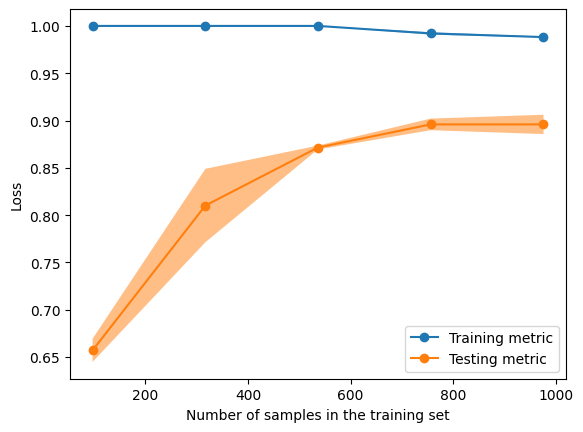

In [19]:
import matplotlib.pyplot as plt

common_params = {
    "X": o_Train_X,
    "y": o_Train_Y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=2, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(plt_testing_gb, **common_params)

plt.show()

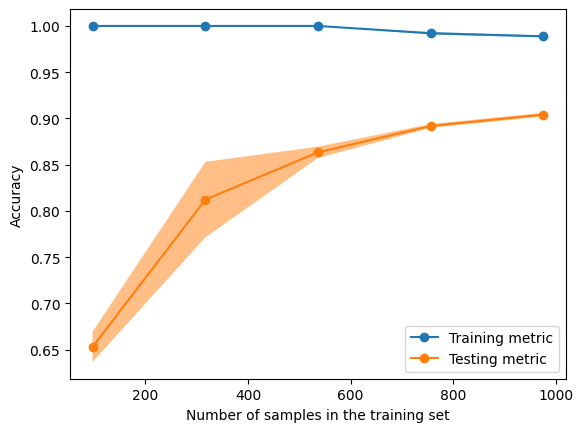

In [18]:
import matplotlib.pyplot as plt

common_params = {
    "X": o_Train_X,
    "y": o_Train_Y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=2, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(plt_testing_gb, **common_params)

plt.show()

## Submit

In [33]:
submit = pd.read_csv('./sample_submission.csv')

In [34]:
submit['Y_Class'] = preds

In [58]:
submit.groupby(['Y_Class']).count()

,PRODUCT_ID
Y_Class,
0,58
1,224
2,28


In [36]:
submit.to_csv('./baseline_submission.csv', index=False)